# Part 1: set up

In [1]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.sklearn

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes

In [2]:
# load train datasets
#get path
import os
train_path = r'train' 
import glob
all_train_files = glob.glob(train_path + "/*.txt")
li = []
for filename in all_train_files:
    #read the text files and merge them into one DataFrame
    df = pd.read_csv(filename, sep=':',header=None)
    li.append(df)
#convert list to DataFrame
train = pd.concat(li, ignore_index=True)

In [3]:
train

,0,1,2,3
0,Joe Biden,I refuse to postpone any longer taking on cli...,NaN,NaN
1,Joe Biden,Because it got done before. I’m the only one ...,NaN,NaN
2,Joe Biden,"No, what I said was, the question… Speak to c...",NaN,NaN
3,Joe Biden,"What Latinos should look at is, comparing thi...",NaN,NaN
4,Joe Biden,What I would do as president is several more ...,NaN,NaN
...,...,...,...,...
523,Andrew Yang,"I would not repeal the tariffs on day one, bu...",NaN,NaN
524,Andrew Yang,"So to follow up on what Elizabeth said, why a...",NaN,NaN
525,Andrew Yang,"Let me be clear, I am pro-good school. I’ve g...",NaN,NaN
526,Andrew Yang,We need to lighten up the emphasis on standar...,NaN,NaN


As the seperate was ':', it may appear in text. Therefore, we have more columns than expected. I need to find the lines with such situation and merge the texts.

In [4]:
train.dropna()

,0,1,2,3
37,Joe Biden,"Well, look, the next president of the United ...","Defeat Donald Trump, that’s number one; and, ...",Who is most likely to do what needs to be don...


There's only one line with multiple ":" in text.

In [5]:
#merge and drop the other two
train.iloc[37][1]=train.iloc[37][1]+train.iloc[37][2]+train.iloc[37][3]
train=train.drop([2,3],axis=1)
#rename the columns
train=train.rename(columns={0:"user",1:"quote"})

In [6]:
# load test datasets
#get path
test_path = r'test' 
all_test_files = glob.glob(test_path + "/*.txt")
li = []
for filename in all_test_files:
    #read the text files and merge them into one DataFrame
    df = pd.read_csv(filename, sep='&',header=None)
    li.append(df)
#convert list to DataFrame
test = pd.concat(li, ignore_index=True)

I found when I didn't set a seperation, the text seperates automatically when there's a notation. So I set & as the seperation, as maybe no text include one. 

In [7]:
test

,0
0,"You know, I served under General Dunford, way ..."
1,"You know, when President Kennedy announced the..."
2,This is a problem which continues to get worse...
3,"Well, first of all, I have no criticism of tha..."
4,I’m running for president because our country ...
...,...
106,Dealing with high-level national security brie...
107,"Sure, there’s one point we’re really missing o..."
108,My entire career has been spent having one cli...
109,At least Bernie’s being honest here and saying...


In [8]:
#rename the columns
test.rename(columns={0:"quote"})

,quote
0,"You know, I served under General Dunford, way ..."
1,"You know, when President Kennedy announced the..."
2,This is a problem which continues to get worse...
3,"Well, first of all, I have no criticism of tha..."
4,I’m running for president because our country ...
...,...
106,Dealing with high-level national security brie...
107,"Sure, there’s one point we’re really missing o..."
108,My entire career has been spent having one cli...
109,At least Bernie’s being honest here and saying...


Are there any instances where the name of the file does not align
with the name at the start of the text?

In [9]:
#get a list of filenames
list=[]
for filename in all_train_files:
    #refine the text a little bit to make it easier later
    name=filename[6:16]
    list.append(name)
#insert a column of filenames
train['filename']=list

In [10]:
# extract the exact Last names 
new=train['filename'].str.split("_",n=1,expand=True)
train['filename']=new[0]
old=train['user'].str.split(" ",n=1,expand=True)
train['username']=old[1]

In [11]:
# compare the two columns to find out whether there's any difference
'False' in train['filename']==train['username']

False

No, so let's move on.

In [12]:
train.groupby('username').count()

,user,quote,filename
username,,,
Biden,60,60,60
Booker,50,50,50
Buttigieg,60,60,60
Castro,23,23,23
Gabbard,16,16,16
Harris,40,40,40
Klobuchar,55,55,55
O'Rourke,33,33,33
Sanders,60,60,60


In [13]:
# Create a vector of training labels
labels=train.username.unique()
len(labels)

12

In [14]:
len(labels), len(train)

(12, 528)

The labels are not evenly distributed in the dataset. There are 12 labels and 528 training data.

In [15]:
#extract only quote from the train DataFrame
training=train.quote
#convert training data to lower case
training=training.str.lower()
# replace lines and tabs
training=training.str.replace('\n',' ')
training=training.str.replace('\t',' ')
#Remove punctuation from the training data.
training=training.str.replace(r"[^\w\s']",' ')
training=training.str.strip()
#remove stop words from the training data using the NLTK package's English stop word list.
stops=stopwords.words('english')
#try PorterStemmer first
stemmer=PorterStemmer()
training=training.apply(lambda x:' '.join([stemmer.stem(word) for word in x.split() if word not in stops]))

are there words specific to this dataset that may be worthwhile
to treat as stop words?  
In order to find out extra stopwords, I want to read some samples.

In [16]:
print(training.sample(5).values)

['yeah think existenti threat human number one issu might add realli need kind lectur friend pass first climat chang bill politifact said game changer manag 90 billion recoveri plan invest money infrastructur relat clean energi time ever done friend produc coal mine produc coal around world accord press great britain produc welcom back fold long idea talk start let get straight think existenti threat time'
 'believ need send somebodi differ kind experi experi ground solv problem work side side neighbor toughest issu come govern recogn requir execut leadership bring washington washington start look littl like best run commun heartland way around start happen'
 'ye need held account financi also crimin penalti know draw straight line make sure hold execut account whether drug manufactur wall street execut held account decad half ago'
 'congressman describ extrem deal negoti american worker american worker american worker want job build trade deal peopl want access market around world ans

In [17]:
#just add some words seems commonplace in any occasions
stops.extend(['us', 'year','come', 'much', 'lot', 'got', 'get', 'around', 'way','upon'])
#clean again
training2=training.apply(lambda x:' '.join([stemmer.stem(word) for word in x.split() if word not in stops]))

In [18]:
#reset stopwords
stops=stopwords.words('english')

import more stemmers from library

In [19]:
from nltk.stem.snowball import EnglishStemmer
stemmerSnow=EnglishStemmer()
from nltk.stem.lancaster import LancasterStemmer
stemmerLanc=LancasterStemmer()

In [20]:
trainSnow=training.apply(lambda x:' '.join([stemmerSnow.stem(word) for word in x.split() if word not in stops]))
trainLanc=training.apply(lambda x:' '.join([stemmerLanc.stem(word) for word in x.split() if word not in stops]))

Take a glance at the data

In [21]:
print("Porter Stemmer")
print(training.head(2).values)
print("English Stemmer")
print(trainSnow.head(2).values)
print("Lancaster Stemmer")
print(trainLanc.head(2).values)

Porter Stemmer
['refus postpon longer take climat chang lead world take climat chang look unit state america never singl solitari time set mind someth abl walk around head like woe best equip nation world take longer time postpon get move enorm enorm opportun get rid donald trump'
 'got done one ever beat nra one ever beat nra nation guy brought bradi bill focu becam law number one number two sandi hook number thing happen went caus movement look happen mother organ mother gun violenc seen happen young peopl march washington make sure thing go chang sea chang propos put forward presid 50 member nra support overwhelmingli rest peopl support number much higher realiz say say correct 90 american peopl think get assault weapon street period get buyback get basement point thing chang thing chang lot happen way way beto handl excus say beto congressman']
English Stemmer
['refus postpon longer take climat chang lead world take climat chang look unit state america never singl solitari time set

I cannot see clearly in details. Let's try length, more straightforward.

In [22]:
len(training[0]),len(trainSnow[0]),len(trainLanc[0])

(263, 263, 236)

In [23]:
len(training[200]),len(trainSnow[200]),len(trainLanc[200])

(173, 172, 141)

In [24]:
len(training[500]),len(trainSnow[500]),len(trainLanc[500])

(288, 286, 233)

PorterStemmer and EnglishStemmer are rather similar. While LancasterStemmer always leads to very different results from the other two.

## CV of original train dataset

In [25]:
#Tokenize your training data using unigrams
#using default max_df & min_df = 1
vec=CountVectorizer(ngram_range=(1,1))
counts=vec.fit_transform(training).toarray()
counts=pd.DataFrame(counts,columns=vec.get_feature_names())
print(counts.shape)
counts

(528, 3371)


,000,02,040,05,10,100,1000,10th,11,12,...,yesterday,yet,yogi,york,young,younger,zealand,zelenski,zero,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
524,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
526,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
# I tried several times here to see the maximum of the values
counts[counts.values>9]
# so the most frequent word appears 10 times in the no.134 document

,000,02,040,05,10,100,1000,10th,11,12,...,yesterday,yet,yogi,york,young,younger,zealand,zelenski,zero,zuckerberg
133,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are 3371 unique tokens in the vocabulary.

In [27]:
#define a function for loop
def try_df(mindf):
    vec=CountVectorizer(ngram_range=(1,1),min_df=mindf)
    counts=vec.fit_transform(training).toarray()
    counts=pd.DataFrame(counts,columns=vec.get_feature_names())
    print("min_df= ", mindf, "token number=", counts.shape[1])

In [28]:
#try different min_dfs
#got value error so I changed the range of mindf
for mindf in np.linspace(0.1,0.5,5):
    try_df(mindf)

min_df=  0.1 token number= 68
min_df=  0.2 token number= 22
min_df=  0.30000000000000004 token number= 6
min_df=  0.4 token number= 1
min_df=  0.5 token number= 1


In [29]:
#repeat the process for maxdf
def try_df(maxdf):
    vec=CountVectorizer(ngram_range=(1,1),max_df=maxdf)
    counts=vec.fit_transform(training).toarray()
    counts=pd.DataFrame(counts,columns=vec.get_feature_names())
    print("max_df= ", maxdf, "token number=", counts.shape[1])

In [30]:
for maxdf in np.linspace(1,0.1,10):
    try_df(maxdf)

max_df=  1.0 token number= 3371
max_df=  0.9 token number= 3371
max_df=  0.8 token number= 3371
max_df=  0.7 token number= 3371
max_df=  0.6 token number= 3371
max_df=  0.5 token number= 3370
max_df=  0.3999999999999999 token number= 3370
max_df=  0.29999999999999993 token number= 3365
max_df=  0.19999999999999996 token number= 3349
max_df=  0.1 token number= 3303


So most of the words seldom appears, only some words appears frequently.

Repeat the process for the test data.

In [31]:
#extract only quote from the train DataFrame
testing=test[0]
#convert training data to lower case
testing=testing.str.lower()
# replace lines and tabs
testing=testing.str.replace('\n',' ')
testing=testing.str.replace('\t',' ')
#Remove punctuation from the training data.
testing=testing.str.replace(r"[^\w\s']",' ')
testing=testing.str.strip()
#remove stop words from the training data using the NLTK package's English stop word list.
stops=stopwords.words('english')
#try PorterStemmer first
stemmer=PorterStemmer()
testing=testing.apply(lambda x:' '.join([stemmer.stem(word) for word in x.split() if word not in stops]))

In [32]:
#fit on the training data
vec=vec.fit(training)
#transform the test data
counts_test=vec.transform(testing).toarray()
counts_test=pd.DataFrame(counts_test,columns=vec.get_feature_names())
print(counts_test.shape)

(111, 3371)


In this way the number of features for your training and test data are identical.

# part 2: supervised learning

because there's no label for test dataset. So, I split the train dataset to find out the model accuracy.

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
train_x, valid_x, train_y, valid_y = train_test_split(training, train.username)

In [35]:
from sklearn.preprocessing import LabelEncoder

In [36]:
# label encode the target variable
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [37]:
#vec was trained on the whole train dataset
xtrain_count =  vec.transform(train_x)
xvalid_count =  vec.transform(valid_x)

In [38]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [39]:
#define a function to run faster for other models
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return classification_report(predictions, valid_y,target_names=labels)

## Logistic Regression

In [40]:
report = train_model(LogisticRegression(), xtrain_count, train_y, xvalid_count)
print (report)

              precision    recall  f1-score   support

       Biden       0.75      0.60      0.67        20
      Booker       0.60      0.33      0.43        18
   Buttigieg       0.53      0.53      0.53        19
      Castro       0.20      0.50      0.29         2
     Gabbard       0.50      1.00      0.67         2
      Harris       0.33      0.60      0.43         5
   Klobuchar       0.44      0.31      0.36        13
    O'Rourke       0.33      0.60      0.43         5
     Sanders       0.71      0.75      0.73        16
      Steyer       0.50      1.00      0.67         3
      Warren       0.64      0.54      0.58        26
        Yang       0.33      0.67      0.44         3

    accuracy                           0.55       132
   macro avg       0.49      0.62      0.52       132
weighted avg       0.58      0.55      0.55       132



The model has an accuracy score of 52%. The class where it performs particularly well is "Sanders". It has the highest precision among all which is 82%. The classes where it performs particularly poorly is "Castro". It has the lowest precision 25% and other scores are also the lowest.

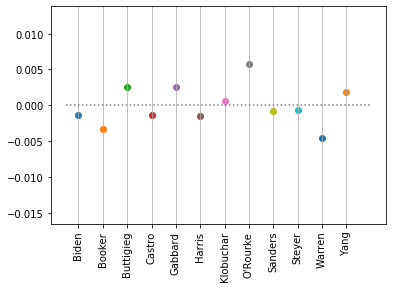

In [41]:
log=LogisticRegression()
log=log.fit(xtrain_count,train_y)
#use a plot to see coef for each label
for i in range(len(labels)):
    plt.scatter(labels[i],np.mean(log.coef_[i]))
plt.xticks(rotation='vertical')
#add a horizontal line at y=0
plt.hlines(0,-0.5,12,colors='grey',linestyle='dotted')
#add grids to match the dot and x axis
plt.grid(axis='x')

The regression coefficient of a variable corresponds to the change in log odds and its exponentiated form corresponds to the odds ratio. 


The coefficients of "Biden", "Castro", "Gabbard", "Klobuchar" and "Steyer" are closest to zero. The coefficients of "Buttigieg", "O'Rourke" and "Yang" are positive. The coefficients of "Booker", "Harris", "Sanders" and "Warren" are negative.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

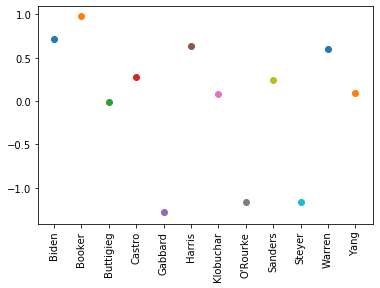

In [42]:
#use a plot to see intercept of each label
for i in range(len(labels)):
    plt.scatter(labels[i],np.mean(log.intercept_[i]))
plt.xticks(rotation='vertical')

The intercept is the expected mean value of Y(labels) when all X=0.

## Tree
### random forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
report = train_model(RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", report)

RF, Count Vectors:                precision    recall  f1-score   support

       Biden       0.75      0.55      0.63        22
      Booker       0.40      0.29      0.33        14
   Buttigieg       0.32      0.60      0.41        10
      Castro       0.00      0.00      0.00         0
     Gabbard       0.00      0.00      0.00         0
      Harris       0.22      0.12      0.16        16
   Klobuchar       0.44      0.27      0.33        15
    O'Rourke       0.11      1.00      0.20         1
     Sanders       0.53      0.64      0.58        14
      Steyer       0.00      0.00      0.00         0
      Warren       0.73      0.41      0.52        39
        Yang       0.17      1.00      0.29         1

    accuracy                           0.42       132
   macro avg       0.31      0.41      0.29       132
weighted avg       0.54      0.42      0.45       132



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy of this randomforest model is poorer than logistic regression. It only receives an accuracy score of 43%. And there are 3 labels "Castro", "Gabbard" and "Yang" with 0 scores. Whereas, the model performs well on labels "Sanders" with precision 82% and "Warren" with precision "70%". 

### boosting model

In [45]:
import xgboost

In [46]:
report = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print (report)

              precision    recall  f1-score   support

       Biden       0.50      0.32      0.39        25
      Booker       0.20      0.17      0.18        12
   Buttigieg       0.42      0.62      0.50        13
      Castro       0.00      0.00      0.00         8
     Gabbard       0.25      0.50      0.33         2
      Harris       0.22      0.20      0.21        10
   Klobuchar       0.33      0.30      0.32        10
    O'Rourke       0.44      0.67      0.53         6
     Sanders       0.47      0.57      0.52        14
      Steyer       0.33      1.00      0.50         2
      Warren       0.55      0.48      0.51        25
        Yang       0.17      0.20      0.18         5

    accuracy                           0.39       132
   macro avg       0.32      0.42      0.35       132
weighted avg       0.39      0.39      0.37       132



The accuracy score is 37%, even poorer than the randomforest model. Though there's only one label "Gabbard" with 0 scores, the overall scores for all the labels are lower than the logistic regression model. The model performs well on label "Sanders" as well. Maybe this Sanders is a special person who may frequently use some certain words.

## naive bayes

In [47]:
from sklearn import naive_bayes

In [48]:
report = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
print(report)

              precision    recall  f1-score   support

       Biden       0.62      0.56      0.59        18
      Booker       0.30      0.30      0.30        10
   Buttigieg       0.53      0.48      0.50        21
      Castro       0.00      0.00      0.00         0
     Gabbard       0.00      0.00      0.00         1
      Harris       0.33      0.60      0.43         5
   Klobuchar       0.78      0.47      0.58        15
    O'Rourke       0.56      1.00      0.71         5
     Sanders       0.65      0.69      0.67        16
      Steyer       0.17      1.00      0.29         1
      Warren       0.82      0.50      0.62        36
        Yang       0.33      0.50      0.40         4

    accuracy                           0.53       132
   macro avg       0.42      0.51      0.42       132
weighted avg       0.63      0.53      0.56       132



The naive bayes model performs the best among all. It has an accuracy score of 58%. I choose this model because we learn naive bayes and bag of words last quarter when we first learned about text processing. More than half of the labels have precision score over 50. Five labels have recall score 100 and they are "Castro", "Gabbard", "Harris", "O'Rourke" and "Steyer". 

## compare the models

In [50]:
#define a function to run faster for other models
#revise the former function to get the score as dataframes
def scores(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
        
    score = pd.DataFrame(classification_report(predictions, valid_y,target_names=labels, output_dict=True)).transpose()
    
    return  score

In [51]:
lr=scores(LogisticRegression(), xtrain_count, train_y, xvalid_count)
rf=scores(RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
nb=scores(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
lr.columns

Index(['precision', 'recall', 'f1-score', 'support'], dtype='object')

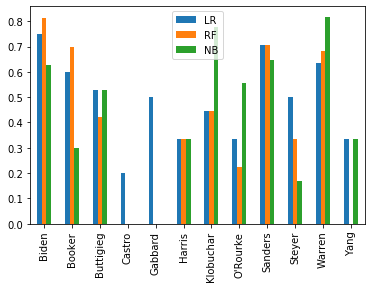

In [53]:
precision=lr.drop(['recall','f1-score','support'],axis=1)
precision=precision.rename(columns={'precision':'LR'})
precision['RF']=rf.precision
precision['NB']=nb.precision
precision.drop(['accuracy','macro avg','weighted avg'],axis=0,inplace=True)
precision.plot.bar()

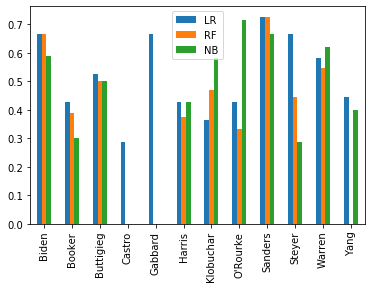

In [54]:
f1=lr.drop(['recall','precision','support'],axis=1)
f1=f1.rename(columns={'f1-score':'LR'})
f1['RF']=rf['f1-score']
f1['NB']=nb['f1-score']
f1.drop(['accuracy','macro avg','weighted avg'],axis=0,inplace=True)
f1.plot.bar()

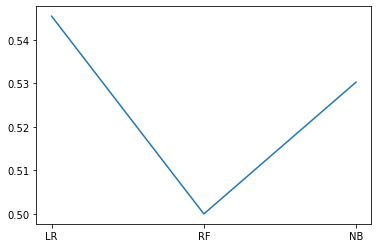

In [55]:
lr_score=lr.iloc[12][0]
rf_score=rf.iloc[12][0]
nb_score=nb.iloc[12][0]
xaxis=['LR','RF','NB']
yaxis=[lr_score,rf_score,nb_score]
plt.plot(xaxis,yaxis)

The strongest model is the naive bayes model and the random forest model is the weakest.

## generate label for the test set

In [56]:
y_train=train.username
y_train= encoder.fit_transform(y_train)

In [57]:
model=naive_bayes.MultinomialNB().fit(counts,y_train)

In [58]:
labels

array(['Biden', 'Booker', 'Buttigieg', 'Castro', 'Gabbard', 'Harris',
       'Klobuchar', "O'Rourke", 'Sanders', 'Steyer', 'Warren', 'Yang'],
      dtype=object)

In [59]:
label=pd.Series(labels)

In [60]:
#upper case
label=label.str.upper()
#remove punctuation
label=label.str.replace("'",'')
#remove blackspace
label=label.str.replace(" ",'')

In [61]:
#transform uppercased label to a dictionary
dict=label.to_dict()

In [62]:
#use model to predict outputs for the test set
pred_test=model.predict(counts_test)
#replace the numeric outputs with uppercased labels
pred_test = [dict[letter] for letter in pred_test]

In [63]:
len(pred_test)

111

# semi-supervised learning

## choose classifier and model

Try tf-idf classifier with different analyzers.

In [64]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(training)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(training)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(training)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


check the accuracy of the better models naive bayes and logistic regression  with tf-idf data

In [65]:
# Naive Bayes on Word Level TF IDF Vectors
report = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print (report)

              precision    recall  f1-score   support

       Biden       0.31      0.71      0.43         7
      Booker       0.10      0.50      0.17         2
   Buttigieg       0.05      0.50      0.10         2
      Castro       0.00      0.00      0.00         0
     Gabbard       0.00      0.00      0.00         0
      Harris       0.00      0.00      0.00         0
   Klobuchar       0.44      0.67      0.53         6
    O'Rourke       0.00      0.00      0.00         0
     Sanders       0.24      1.00      0.38         4
      Steyer       0.00      0.00      0.00         0
      Warren       1.00      0.20      0.33       111
        Yang       0.00      0.00      0.00         0

    accuracy                           0.28       132
   macro avg       0.18      0.30      0.16       132
weighted avg       0.89      0.28      0.34       132



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
report = train_model(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print (report)

              precision    recall  f1-score   support

       Biden       0.44      0.78      0.56         9
      Booker       0.30      0.75      0.43         4
   Buttigieg       0.16      0.75      0.26         4
      Castro       0.00      0.00      0.00         0
     Gabbard       0.00      0.00      0.00         0
      Harris       0.11      1.00      0.20         1
   Klobuchar       0.44      0.67      0.53         6
    O'Rourke       0.11      1.00      0.20         1
     Sanders       0.47      0.67      0.55        12
      Steyer       0.00      0.00      0.00         0
      Warren       1.00      0.23      0.38        95
        Yang       0.00      0.00      0.00         0

    accuracy                           0.37       132
   macro avg       0.25      0.49      0.26       132
weighted avg       0.83      0.37      0.41       132



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
report = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print (report)

              precision    recall  f1-score   support

       Biden       0.00      0.00      0.00         1
      Booker       0.00      0.00      0.00         0
   Buttigieg       0.00      0.00      0.00         0
      Castro       0.00      0.00      0.00         0
     Gabbard       0.00      0.00      0.00         0
      Harris       0.00      0.00      0.00         0
   Klobuchar       0.00      0.00      0.00         0
    O'Rourke       0.00      0.00      0.00         0
     Sanders       0.00      0.00      0.00         0
      Steyer       0.00      0.00      0.00         0
      Warren       1.00      0.17      0.29       131
        Yang       0.00      0.00      0.00         0

    accuracy                           0.17       132
   macro avg       0.08      0.01      0.02       132
weighted avg       0.99      0.17      0.29       132



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
report = train_model(LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print (report)

              precision    recall  f1-score   support

       Biden       0.81      0.65      0.72        20
      Booker       0.50      0.33      0.40        15
   Buttigieg       0.47      0.53      0.50        17
      Castro       0.00      0.00      0.00         0
     Gabbard       0.00      0.00      0.00         0
      Harris       0.33      0.75      0.46         4
   Klobuchar       0.67      0.40      0.50        15
    O'Rourke       0.22      1.00      0.36         2
     Sanders       0.53      0.90      0.67        10
      Steyer       0.00      0.00      0.00         0
      Warren       0.91      0.41      0.56        49
        Yang       0.00      0.00      0.00         0

    accuracy                           0.51       132
   macro avg       0.37      0.41      0.35       132
weighted avg       0.71      0.51      0.56       132



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
report = train_model(LogisticRegression(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print (report)

              precision    recall  f1-score   support

       Biden       0.44      0.70      0.54        10
      Booker       0.40      0.57      0.47         7
   Buttigieg       0.21      0.80      0.33         5
      Castro       0.00      0.00      0.00         0
     Gabbard       0.00      0.00      0.00         0
      Harris       0.11      1.00      0.20         1
   Klobuchar       0.56      0.45      0.50        11
    O'Rourke       0.11      1.00      0.20         1
     Sanders       0.35      0.60      0.44        10
      Steyer       0.00      0.00      0.00         0
      Warren       0.95      0.24      0.39        87
        Yang       0.00      0.00      0.00         0

    accuracy                           0.37       132
   macro avg       0.26      0.45      0.26       132
weighted avg       0.77      0.37      0.41       132



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
report = train_model(LogisticRegression(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print (report)

              precision    recall  f1-score   support

       Biden       0.50      0.57      0.53        14
      Booker       0.50      0.42      0.45        12
   Buttigieg       0.32      0.50      0.39        12
      Castro       0.00      0.00      0.00         0
     Gabbard       0.00      0.00      0.00         0
      Harris       0.33      1.00      0.50         3
   Klobuchar       1.00      0.33      0.50        27
    O'Rourke       0.11      1.00      0.20         1
     Sanders       0.47      0.73      0.57        11
      Steyer       0.00      0.00      0.00         0
      Warren       0.86      0.37      0.51        52
        Yang       0.00      0.00      0.00         0

    accuracy                           0.45       132
   macro avg       0.34      0.41      0.30       132
weighted avg       0.72      0.45      0.50       132



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All the results are lower than the CountVectorizer classifier. So I give up the tf-idf classifier.   
I don't feel any delay while running these codes.  All of them are running fast.  
Therefore, I choose CountVectorizer classifier and naive bayes model.

## predict label probabilities on the test set

In [71]:
proba=model.predict_proba(counts_test)
proba=pd.DataFrame(proba)

#maximum value of each row
index=proba.idxmax(axis=1)

Take the top 10% of test instances which have the highest
probability of having the correct labels (i.e. the highest probabilities of belonging to any class).

In [72]:
list=[]
for i in np.arange(len(proba)):
    list.append(proba.iloc[i].sum())
proba['sum']=list

top=proba.sort_values(by=['sum'],ascending=False).head(int(len(proba)*0.1))

top.drop(['sum'],axis=1,inplace=True)

Add predicted labels to this 10% and then add it to the training data.

In [73]:
#get the index of the top set
top_index=top.index.tolist()
#remove the top data from proba
proba.drop(top_index,inplace=True)
#extract the count converted data using index
top_test=counts_test.iloc[top_index]

#predict the labels of the top set
pred_top=model.predict(top_test)

In [74]:
pred_top

array([ 6, 10,  6,  2, 10,  1,  8,  0,  8,  2, 10])

In [75]:
#before
counts.shape

(528, 3371)

turn xtrain_count from sparse matrix to a dataframe in order to add the top test set

xtrain_count=vec.transform(train_x).toarray()
xtrain_count=pd.DataFrame(xtrain_count,columns=vec.get_feature_names())

In [76]:
#add top set and their predictions to the training data
x_train=counts.append(top_test,ignore_index=True)

In [77]:
#after
x_train.shape

(539, 3371)

In [78]:
y_train=np.append(y_train,pred_top)

In [79]:
#check whether y is comformed with x
y_train.shape

(539,)

successfully added the 10%

In [80]:
#retrain on the updated training set and get the report
model =model.fit(x_train, y_train)
prediction=model.predict(xvalid_count)
print (classification_report(prediction, valid_y,target_names=labels))

              precision    recall  f1-score   support

       Biden       1.00      0.94      0.97        17
      Booker       1.00      1.00      1.00        10
   Buttigieg       1.00      0.95      0.97        20
      Castro       1.00      1.00      1.00         5
     Gabbard       0.75      1.00      0.86         3
      Harris       1.00      1.00      1.00         9
   Klobuchar       1.00      1.00      1.00         9
    O'Rourke       0.89      1.00      0.94         8
     Sanders       1.00      1.00      1.00        17
      Steyer       1.00      1.00      1.00         6
      Warren       1.00      0.96      0.98        23
        Yang       0.83      1.00      0.91         5

    accuracy                           0.98       132
   macro avg       0.96      0.99      0.97       132
weighted avg       0.98      0.98      0.98       132



Compared to the accuracy on the original training data (should be 100), now it's only 0.98, decreased by 0.02.  

In [81]:
#generate two lists for the plot
#add the two points we already have
ydata=[1.00,accuracy_score(prediction,valid_y).round(4)]
xdata=['0%','10%']

In [82]:
for iter in range(2,11):

    top=proba.sort_values(by=['sum'],ascending=False).head(11)

    top.drop(['sum'],axis=1,inplace=True)
    #get the index of the top set
    top_index=top.index.tolist()
    #remove the top data from proba
    proba.drop(top_index,inplace=True)
    #extract the count converted data using index
    top_test=counts_test.iloc[top_index]

    #predict the labels of the top set
    pred_top=model.predict(top_test)
    #add top set and their predictions to the training data
    x_train=x_train.append(top_test,ignore_index=True)
    y_train=np.append(y_train,pred_top)
    #retrain on the updated training set and get the report
    model =model.fit(x_train, y_train)
    prediction=model.predict(xvalid_count)
    accuracy=accuracy_score(prediction, valid_y)
    ydata.append(accuracy.round(4))
    xdata.append(str(iter*10)+'%')

draw a line plot to see how accuracy changed as I add more test data to the original train set

Text(0.5, 1.0, 'the classification accuracy on the original training dataset')

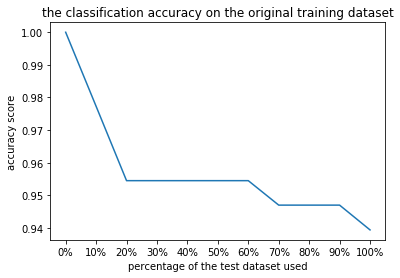

In [83]:
plt.plot(xdata,ydata)
plt.ylabel('accuracy score')
plt.xlabel('percentage of the test dataset used')
plt.title('the classification accuracy on the original training dataset')

The accuracy score mostly decreases as more test data added to the original training set.

In [84]:
#Using the model that is trained on the entirety of the training data and 100% of the test data
final_model=model
#generate a final set of labels for the test data.
predictions = final_model.predict(counts_test)
#only use last names in all caps for the labels
predictions = [dict[letter] for letter in predictions]

In [85]:
predictions

['BUTTIGIEG',
 'BIDEN',
 'WARREN',
 'SANDERS',
 'BUTTIGIEG',
 'WARREN',
 'GABBARD',
 'BUTTIGIEG',
 'OROURKE',
 'WARREN',
 'KLOBUCHAR',
 'KLOBUCHAR',
 'SANDERS',
 'BIDEN',
 'HARRIS',
 'BUTTIGIEG',
 'WARREN',
 'WARREN',
 'BIDEN',
 'BOOKER',
 'BOOKER',
 'STEYER',
 'HARRIS',
 'WARREN',
 'HARRIS',
 'BUTTIGIEG',
 'BOOKER',
 'BIDEN',
 'SANDERS',
 'WARREN',
 'WARREN',
 'HARRIS',
 'SANDERS',
 'WARREN',
 'BOOKER',
 'BUTTIGIEG',
 'WARREN',
 'SANDERS',
 'WARREN',
 'WARREN',
 'SANDERS',
 'BUTTIGIEG',
 'WARREN',
 'WARREN',
 'HARRIS',
 'KLOBUCHAR',
 'BUTTIGIEG',
 'OROURKE',
 'BUTTIGIEG',
 'BOOKER',
 'KLOBUCHAR',
 'SANDERS',
 'WARREN',
 'BOOKER',
 'WARREN',
 'WARREN',
 'WARREN',
 'BIDEN',
 'BUTTIGIEG',
 'BIDEN',
 'GABBARD',
 'BUTTIGIEG',
 'BUTTIGIEG',
 'SANDERS',
 'BIDEN',
 'WARREN',
 'KLOBUCHAR',
 'WARREN',
 'KLOBUCHAR',
 'WARREN',
 'BUTTIGIEG',
 'BIDEN',
 'WARREN',
 'BUTTIGIEG',
 'BUTTIGIEG',
 'BIDEN',
 'SANDERS',
 'GABBARD',
 'BUTTIGIEG',
 'KLOBUCHAR',
 'BOOKER',
 'WARREN',
 'HARRIS',
 'BUTTIGIEG',

# Submission

In [86]:
#get the file names
output=pd.DataFrame(all_test_files,columns=['FILE'])
#clean the file names
output=output['FILE'].str.split('\\',n=1,expand=True)
output.columns=['drop','FILE']
output.drop(['drop'],axis=1,inplace=True)
#add predictions from Q12 AND Q16 to the output form
output['MODEL1']=pred_test
output['MODEL2']=predictions

In [87]:
accuracy_score(pred_test,predictions)

0.9099099099099099

There are nuance differences between the outputs of Q12 and Q16. But they are mostly alike.

In [88]:
output.to_csv(r'PS3_output.txt', header=output.columns,index=None,sep='\t')